# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

try:  
    from neel_plotly import imshow, scatter 
except ImportError:
    print("neel_plotly not found, installing it now...")
    %pip install git+https://github.com/neelnanda-io/neel-plotly.git
    
import torch
from torch import Tensor
from IPython.display import HTML

from functools import partial
import einops
from typing import List, Tuple, Dict
from jaxtyping import Float, Bool
from rich.table import Table, Column
from rich import print as rprint

import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint

torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

# all these are taken from https://github.com/callummcdougall/ARENA_2.0/blob/main/chapter0_fundamentals/exercises/plotly_utils.py
update_layout_set = {"xaxis_range", "yaxis_range", "yaxis2_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "xaxis_tickangle"}
from transformer_lens.utils import to_numpy

def bar(tensor, renderer=None, **kwargs):
    '''
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    px.bar(y=to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()

def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

%load_ext autoreload
%autoreload 2

Disabled automatic differentiation


This notebook demonstrates a set of core mechanistic interpretability methods using the **Indirect Object Identification (IOI)** task: 
- **Circuit Discovery Tools**: task-specific methods that help uncover how a model solves a particular task; in our case, IOI.

# Note

This notebook assumes familiarity with basic Transformer components (residual stream, attention heads, MLPs) and introduces & explains (IMO) valuable interpretability tools to analyze and reverse-engineer Transformers. For any unfamiliar terms, refer to Neel Nanda’s [glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=disz2gTx-jooAcR0a5r8e7LZ£), or the Transformer Lens docs.

Some of the technical explanations are either taken directly from companion or tutorial notebooks from [TransformerLens](https://transformerlensorg.github.io/TransformerLens/) or other researchers (which I hope that I managed to cite) or paraphrased and adapted to my reimplementation of the method. I also want add that for simple stuff, e.g. defining the prompt dataset with corruption, I did not mention the source because this would've undoubtedly lead to a overflowing with many references.

# Setup

In [2]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",   
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)     
device: torch.device = utils.get_device()
model = model.to(device)                         

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


## Task Setup

We are going to use IOI task in order to exemplify our selected interpretability methods, which we gathered from various resources (cited in the README and throughout the notebook) and centralized in this repo, and as a bonus replicate the findings of the paper (from Callum McDougall's [ARENA tutorial](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=jHjUFdAPl6ma)). 

The IOI task has been extensively studied in interpability literature, with studies ranging from causal mediation analysis (https://arxiv.org/pdf/2211.00593, https://arxiv.org/pdf/2304.05969, https://arxiv.org/pdf/2305.15054, https://arxiv.org/pdf/2403.00745v1) to mechanistic universality (https://arxiv.org/pdf/2310.08744) and explaining attention heads (https://arxiv.org/pdf/2310.04625, https://arxiv.org/pdf/2312.09230) and emergent model behavior (https://arxiv.org/pdf/2307.15771), and as a benchmark for automatic circuit discovery (https://arxiv.org/pdf/2304.14997) and for circuits formed in sparse training (https://arxiv.org/pdf/2505.00509). 

It is a subject-verb-object task in natural language simple enough to reverse-engineer (albeit using SLMs). Concretely given the sentence `When John and Mary went to the shops, John gave the bag to ...` we expect the model to return Mary, i.e. the indirect object, inferring that the IO is the name for which the subject, John is performing the action towards. This allows for forming the hypothesis that in order to answer correctly, the language model should count the number of appearances of each name and output the name that occurs only once. This is in fact the behavior that the [IOI paper](https://arxiv.org/pdf/2211.00593) found and explained in GPT-2 Small (124M parameters). 

This type of natural language task requires the model to choose the answer from the context (appropriately named and frequently used in lit as In-Context Learning; `ICL`), irrespective of factual information about perhaps semantics, favoring instead surface-level heuristics (e.g. frequency statistics: n-grams), but this is only a possible plausible solution from many more complicated ones.

Below we use the `test_prompt` function that returns the top-k probabilities of token following the last token in the prompt and we see a rank difference of 4 between the correct answer ` Mary` (important, with prepended space) and the incorrect answer `John`, and a 67.5 % difference in probability and 4.2 in log probabilities (or logits), i.e. a $e^{4.2}\approx 67\times$ higher probability on the correct answer.

In [3]:
utils.test_prompt(model=model, prompt="When John and Mary went to the shops, John gave the bag to", answer=" Mary")

Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.19 Prob: 69.93% Token: | Mary|

Top 0th token. Logit: 18.19 Prob: 69.93% Token: | Mary|
Top 1th token. Logit: 15.82 Prob:  6.49% Token: | them|
Top 2th token. Logit: 15.48 Prob:  4.66% Token: | the|
Top 3th token. Logit: 14.93 Prob:  2.66% Token: | his|
Top 4th token. Logit: 14.86 Prob:  2.49% Token: | John|
Top 5th token. Logit: 14.12 Prob:  1.19% Token: | her|
Top 6th token. Logit: 13.99 Prob:  1.04% Token: | their|
Top 7th token. Logit: 13.70 Prob:  0.78% Token: | a|
Top 8th token. Logit: 13.53 Prob:  0.66% Token: | him|
Top 9th token. Logit: 13.39 Prob:  0.57% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

All methods needs a special formatting of the task into prompts and answers tokens in pairs of **correct/incorrect** answers. See the example below: 

- All prompts are recommanded to be of equal length, if possible. 
- If working with prompts of variable lengths, there is the option of performing padding on the left side of the prompt, such that the end tokens are at the exact token position. By default, padding is done by adding the flag: `model.to_tokens(prompts, padding_side='left')` which automatically pads up to the maximum length from all prompts.

In [4]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
name_pairs = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]

# Define 8 prompts, in 4 groups of 2 (with adjacent prompts having answers swapped)
prompts = [
    prompt.format(name)
    for (prompt, names) in zip(prompt_format, name_pairs) for name in names[::-1]
]
# Define the answers for each prompt, in the form (correct, incorrect)
answers = [names[::i] for names in name_pairs for i in (1, -1)]
# Define the answer tokens (same shape as the answers)
answer_tokens = torch.concat([
    model.to_tokens(names, prepend_bos=False).T for names in answers
])

tokens = model.to_tokens(prompts, prepend_bos=True)
tokens = tokens.to(device)

original_logits, cache = model.run_with_cache(tokens)

rprint(prompts)
rprint(answers)
rprint(answer_tokens)
rprint(tokens.shape)

[
    'When John and Mary went to the shops, John gave the bag to',
    'When John and Mary went to the shops, Mary gave the bag to',
    'When Tom and James went to the park, James gave the ball to',
    'When Tom and James went to the park, Tom gave the ball to',
    'When Dan and Sid went to the shops, Sid gave an apple to',
    'When Dan and Sid went to the shops, Dan gave an apple to',
    'After Martin and Amy went to the park, Amy gave a drink to',
    'After Martin and Amy went to the park, Martin gave a drink to'
]

[
    (' Mary', ' John'),
    (' John', ' Mary'),
    (' Tom', ' James'),
    (' James', ' Tom'),
    (' Dan', ' Sid'),
    (' Sid', ' Dan'),
    (' Martin', ' Amy'),
    (' Amy', ' Martin')
]

tensor([[ 5335,  1757],
        [ 1757,  5335],
        [ 4186,  3700],
        [ 3700,  4186],
        [ 6035, 15686],
        [15686,  6035],
        [ 5780, 14235],
        [14235,  5780]], device='cuda:0')

torch.Size([8, 15])

<!-- ## Observational Methods (2) -->

### Defining the task metric

We use the **Logit Difference** between the wanted and unwanted answer token. The reason logit difference is suitable for tasks such as IOI where the answer token is found in-context is that we can measure which token the model promotes as opposed to a something we don't want, i.e. as an unwanted behaviour, and because we ultimately care about the final predictions, which happens localised on the final token in the sequence (appropriate for next-token prediction). 

#### Background and motivation of the logit difference

Logit difference is actually a *really* nice and elegant metric and is a particularly nice aspect of the setup of Indirect Object Identification. In general, there are two natural ways to interpret the model's outputs: the output logits, or the output log probabilities (or probabilities).

The logits are much nicer and easier to understand, as noted above. However, the model is trained to optimize the cross-entropy loss (the average of log probability of the correct token). This means it does not directly optimize the logits, and indeed if the model adds an arbitrary constant to every logit, the log probabilities are unchanged.

But we have:

```
log_probs == logits.log_softmax(dim=-1) == logits - logsumexp(logits)
```

and so:

```
log_probs(" Mary") - log_probs(" John") = logits(" Mary") - logits(" John")
```

- the ability to add an arbitrary constant cancels out!

<details>
<summary>Technical details (if this equivalence doesn't seem obvious to you)</summary>

Let $\vec{\textbf{x}}$ be the logits, $\vec{\textbf{L}}$ be the log probs, and $\vec{\textbf{p}}$ be the probs. Then we have the following relations:

$$
p_i = \operatorname{softmax}(\vec{\textbf{x}})_i = \frac{e^{x_i}}{\sum_{i=1}^n e^{x_i}}
$$

and:

$$
L_i = \log p_i
$$

Combining these, we get:

$$
L_i = \log \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}} = x_i - \log \sum_{j=1}^n e^{x_j}
$$

Notice that the sum term on the right hand side is the same for all $i$, so we get:

$$
L_i - L_j = x_i - x_j
$$

in other words, the logit diff $x_i - x_j$ is the same as the log prob diff. This motivates the choice of logit diff as our choice of metric (since the model is directly training to make the log prob of the correct token large, and all other log probs small).

</details>

Further, the metric helps us isolate the precise capability we care about - figuring out *which* name is the Indirect Object. There are many other components of the task - deciding whether to return an article (the) or pronoun (her) or name, realising that the sentence wants a person next at all, etc. By taking the logit difference we control for all of that.

Getting an **output logit** is equivalent to projecting onto a direction in the residual stream. We use `model.tokens_to_residual_directions` to map the answer tokens to that direction, and then convert this to a logit difference direction for each batch.

From docstring:
- "Maps tokens to a tensor with the unembedding vector for those tokens, i.e. the vector in the residual stream that we dot with to the get the logit for that token."

**Average logit difference** vs **Per prompt logit difference** (zoomed out perspective):

- with the first we can get an approximation on how the model performs the task overall
- with the second we can see it's behaviour somehow clearly, inspecting what the model is doing in extreme cases, or how the model learns to do the task better, i.e. by increasing the number of prompts

Function details: 

<span style="color:yellow;">**logits_to_ave_logit_diff**</span>: 

- <span style="background-color :blue;">original_logits</span> = Tensor, shape `(batch, seq_len, vocab_size)`
- <span style="background-color :blue;">answer_tokens</span> = List[Tensor]: example: (`correct_tok_id, wrong_tok_id`) 
- <span style="background-color :blue;">per_prompt</span> = Bool to print the logit difference for each prompt or the average across all prompts

In [5]:
from src.observational.direct_logit_attribution import logits_to_ave_logit_diff

original_per_prompt_diff = logits_to_ave_logit_diff(original_logits, answer_tokens, per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt",
    Column("Correct", style="rgb(0,200,0) bold"),
    Column("Incorrect", style="rgb(255,0,0) bold"),
    Column("Logit Difference", style="bold")
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

Per prompt logit difference: tensor([3.3367, 3.2016, 2.7095, 3.7975, 1.7204, 5.2812, 2.6008, 5.7674],
       device='cuda:0')
Average logit difference: tensor(3.5519, device='cuda:0')


                                             Logit differences                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                                        ┃ Correct   ┃ Incorrect ┃ Logit Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the bag to    │ ' Mary'   │ ' John'   │ 3.337            │
│ When John and Mary went to the shops, Mary gave the bag to    │ ' John'   │ ' Mary'   │ 3.202            │
│ When Tom and James went to the park, James gave the ball to   │ ' Tom'    │ ' James'  │ 2.709            │
│ When Tom and James went to the park, Tom gave the ball to     │ ' James'  │ ' Tom'    │ 3.797            │
│ When Dan and Sid went to the shops, Sid gave an apple to      │ ' Dan'    │ ' Sid'    │ 1.720            │
│ When Dan and Sid went to the shops, Dan gave an apple to      │ ' Sid'    │ ' Dan'    │ 5.281            │
│ After Martin and Amy went to the park, Amy gave a drink to    │ ' Martin' │ ' Amy'    │ 2.601            │
│ After Martin and Amy went to the park, Martin gave a drink to │ ' Amy'    │ ' Martin' │ 5.767            │
└───────────────────────────────────────────────────────────────┴───────────┴───────────┴──────────────────┘

In [6]:
exponential = math.exp(3.5519)
exponential

34.87952566868286

Average logit difference is 3.5519, this represents putting an $e^{3.5519}\approx 35\times$ higher probability on the correct answer.


# Circuit Discovery Tools (Task-Specific)

The following methods are used to discover or validate circuits responsible for model behavior on a specific task. In this notebook, we apply them to the IOI task, which has a known interpretable natural language structure of "subject-verb-object"; we know the correct token (IO) and an incorrect token (S) and define clean/corrupt prompts by swapping their places or even adding a distractor or a placeholder on the position of the IO token would have originally been. 

The following methods apply interventions to model computation and rely on the theory of causality (https://arxiv.org/pdf/1301.2300) and causal mediation analysis (https://arxiv.org/pdf/2408.01416) in order to attribute the functional role of each component to solving task and of task-specificity, i.e. whether the component is required for the modal to minimally and faithfully solve the task, or it is part of some distributed or more complicated behavior involving or building upon our task in-hand, provided that we think of the model as a circuit where nodes are the components of the Transformer, i.e. Attention heads, MLPs or individual neurons and edges are interactions between them.

![Causal Effects](figures/Causal_Effects.png)

## Interventional Methods (Patching)

### Activation Patching

Activation Patching is an efficient method for determining the importance of a component in the Transformer for the final prediction. Essentially, it measures the causal influence of an internal component on model outputs by replacing its activation from one context into another and observing the change in behavior. It has been widely adopted as a principal method for doing exploratory interpretability and people even wrote papers arguing its' relevance, and pointing out their downsides and failure modes (https://arxiv.org/pdf/2309.16042, https://arxiv.org/pdf/2311.17030, https://arxiv.org/pdf/2404.15255). 

It works by running the model on a clean prompt and taking a specific activation and then running the model on a corrupted prompt. We then patch the clean activation and measure the change in Logit Difference (patching means replacing the corrupted activation with the clean activation in the corrupted prompt). If patching in that specific activations promotes significantly the desired token on a corrupted prompt where the correct token (from the clean prompt) is unlikely to be predicted, then the component whose activation we patched is significant for the right outcome and we can consider it for our circuit. 

For more details check this section from the Mech-Interp [Glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx) by Neel Nanda.

- see below the difference between the clean and corrupted IOI prompts for a clearer picture of how we can set counterfactual prompts.




In [7]:
clean_tokens = tokens
# Swap each adjacent pair to get corrupted tokens
indices = [i+1 if i % 2 == 0 else i-1 for i in range(len(tokens))]
corrupted_tokens = clean_tokens[indices]

# answer_tokens for corrupted prompts: swap the correct/incorrect answer
corrupt_answers = [tuple(reversed(a)) for a in answers]
answer_tokens_corr = torch.concat([
    model.to_tokens(names, prepend_bos=False).T for names in corrupt_answers
])

print(
    "Clean string 0:    ", model.to_string(clean_tokens[0]), "\n"
    "Corrupted string 0:", model.to_string(corrupted_tokens[0])
)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean string 0:     <|endoftext|>When John and Mary went to the shops, John gave the bag to 
Corrupted string 0: <|endoftext|>When John and Mary went to the shops, Mary gave the bag to
Clean logit diff: 3.5519
Corrupted logit diff: -3.5519


In [8]:
cols = [
    "Clean Prompts",
    "Corrupted Prompts"
]
table = Table(*cols, title="Clean vs Corrupted Prompts")

clean_prompts = prompts
# Remove the <|endoftext|> token from corrupted prompts
corrupted_prompts = [p.replace("<|endoftext|>", "").strip() for p in [model.to_string(corr_toks) for corr_toks in corrupted_tokens]]

for clean, corr in zip(clean_prompts, corrupted_prompts):
    table.add_row(clean, corr)

rprint(table)

                                            Clean vs Corrupted Prompts                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Clean Prompts                                          ┃ Corrupted Prompts                                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ When John and Mary went to the shops, John gave the    │ When John and Mary went to the shops, Mary gave the    │
│ bag to                                                 │ bag to                                                 │
│ When John and Mary went to the shops, Mary gave the    │ When John and Mary went to the shops, John gave the    │
│ bag to                                                 │ bag to                                                 │
│ When Tom and James went to the park, James gave the    │ When Tom and James went to the park, Tom gave the ball │
│ ball to                                                │ to                                                     │
│ When Tom and James went to the park, Tom gave the ball │ When Tom and James went to the park, James gave the    │
│ to                                                     │ ball to                                                │
│ When Dan and Sid went to the shops, Sid gave an apple  │ When Dan and Sid went to the shops, Dan gave an apple  │
│ to                                                     │ to                                                     │
│ When Dan and Sid went to the shops, Dan gave an apple  │ When Dan and Sid went to the shops, Sid gave an apple  │
│ to                                                     │ to                                                     │
│ After Martin and Amy went to the park, Amy gave a      │ After Martin and Amy went to the park, Martin gave a   │
│ drink to                                               │ drink to                                               │
│ After Martin and Amy went to the park, Martin gave a   │ After Martin and Amy went to the park, Amy gave a      │
│ drink to                                               │ drink to                                               │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

### Residual Stream Patching

We first define a metric for our task, which is **normalized logit difference**, by subtracting the corrupted logit difference, and dividing by the total improvement from clean to corrupted to normalise. 

- 0 means zero change 

- negative means actively made worse

- 1 means totally recovered clean performance

- `>` 1 means actively improved on clean performance

We can patch in the residual stream in 2 ways: 

1. by using the <span style='color: lightgreen'>transformer_lens.patching</span>, helper module. Here we use <span style='color: yellow'>patching.get_act_patch_resid_pre</span>, a function built on top of the more general `generic_activation_patch`, which requires: 

    -  <span style="background-color: blue">**model**</span>
    -  <span style="background-color: blue">**corrupted_tokens**</span>: The input tokens for the corrupted run of, shape [`batch`, `pos`]
    -  <span style="background-color: blue">**clean_cache**</span>: The cached activations from the clean run
    -  <span style="background-color: blue">**patching_metric**</span>: A function from the model's output logits to some metric (e.g. loss, logit diff, etc.)

2. we do the intervention using TransformerLens's `HookPoint` feature. We can design a hook function that takes in a specific activation and returns an edited copy, and temporarily add it in with `model.run_with_hooks`.

In [9]:
# 1 - using `transformer_lens.patching` 
from transformer_lens import patching

# define the metric
def ioi_metric(logits=corrupted_logits, 
                 answer_tokens=answer_tokens, 
                 corr_logit_diff=corrupted_logit_diff, 
                 clean_logit_diff=clean_logit_diff):
    # Normalized logit diff
    patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=corrupted_tokens,
    clean_cache=cache,
    patching_metric=ioi_metric,
)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=1200
)

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:01<00:00, 111.35it/s]


The model promotes significantly the correct answer, i.e the `S` token "John" from layer 0 up to layer 8, and then moves the information to the `END` token " - " in the final three layers.

Interestingly, the model also looks at incorrect token `IO` token "Mary" but it promotes it negatively, i.e. writing in the opposite direction in the residual stream (see the Writing Directions of Name Movers section in `ioi_observational.ipynb`).

We now intervene on the corrupted run and patch in the clean residual stream at a specific layer and position.

In [10]:
# 2 - manual patching
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_logit_diff) / (
        clean_logit_diff - corrupted_logit_diff
    )

patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, clean_tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(clean_tokens.shape[1]): 
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
            patched_logit_diff
        )

prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

### Block Patching (Attention/MLP)

1. We can apply exactly the same idea, but this time patching in Attention or MLP blocks. These are also residual components with identical shapes to the residual stream terms, so we can reuse the same hooks.

2. We can reproduce this with <span style='color: yellow'>patching.get_act_patch_block_every</span>, that patches to `resid_pre`, `attn_out` and `mlp_out`.  


In [11]:
# 1 - manual
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, clean_tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, clean_tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(clean_tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = logits_to_ave_logit_diff(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )
        patched_mlp_diff[layer, position] = normalize_patched_logit_diff(
            patched_mlp_logit_diff
        )

imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention block",
    labels={"x": "Position", "y": "Layer"},
)

We can see that `MLP0` matters a lot, acting as an extention of the Embedding layer and that when later layers want to access the input tokens they mostly read in the output of the first MLP layer, rather than the token embeddings.


<details><summary>Note on `patching.get_act_patch_block_every`</summary>

One important thing to note - we're cycling through the `resid_pre`, `attn_out` and `mlp_out` and only patching one of them at a time, rather than patching all three at once.

</details>

In [12]:
# 2
act_patch_block_every = patching.get_act_patch_block_every(model, corrupted_tokens, cache, ioi_metric)

imshow(
    act_patch_block_every,
    x=labels,
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Residual Stream", "Attn Output", "MLP Output"], # Subtitles of separate plots
    title="Logit Difference From Patched Blocks",
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1400,
)

  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:01<00:00, 111.41it/s]


### Attention Heads Patching

We can refine the above analysis by patching in individual head outputs!

1. Coding it up, the easiest way to do this is to patch in the activation `z`, the "mixed value" of the attention head. That is, the average of all previous values weighted by the attention pattern, ie the activation that is then multiplied by `W_O`, the output weights.

2. We can also do it just by  <span style='color: yellow'>patching.act_patch_attn_head_out_all_pos</span>.

In [13]:
# 1
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector
   
patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

In [14]:
# 2
act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(
    model,
    corrupted_tokens,
    cache,
    ioi_metric
)

imshow(
    act_patch_attn_head_out_all_pos,
    labels={"y": "Layer", "x": "Head"},
    title="Attention Head Output Activation Patching (All Pos)",
    width=1200
)

  0%|          | 0/144 [00:00<?, ?it/s]

100%|██████████| 144/144 [00:02<00:00, 49.35it/s]


### Attention Head Decomposition

Decomposing attention layers into patching in individual heads has already helped us localise the behaviour a lot. But we can understand it further by decomposing heads. An attention head consists of two semi-independent operations - calculating _where_ to move information _from and to_ (represented by the attention pattern and implemented via the **QK circuit**) and calculating _what_ information to move (represented by the value vectors and implemented by the **OV circuit**). We can disentangle which of these is important by patching in just the attention pattern or the value vectors.

1. First let's patch in the value vectors, to measure when figuring out what to move is important. This has the same shape as z (`[batch, pos, head_index, d_head]`) so we can reuse the same hook.

2. Or with <span style='color: yellow'>patching.act_patch_attn_head_all_pos_every</span>

In [15]:
# 2
act_patch_attn_head_all_pos_every = patching.get_act_patch_attn_head_all_pos_every(
    model,
    corrupted_tokens,
    cache,
    ioi_metric
)

imshow(
    act_patch_attn_head_all_pos_every,
    facet_col=0,
    facet_labels=["Attn Output", "Query", "Key", "Value", "Attn Pattern"],
    title="Activation Patching Per Head (All Pos)",
    labels={"x": "Head", "y": "Layer"},
)

  0%|          | 0/144 [00:00<?, ?it/s]

100%|██████████| 144/144 [00:02<00:00, 57.88it/s]


In [16]:
# 1
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][:, head_index, :, :]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Attn Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)

In [17]:
# 1
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens)

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
)

In [18]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

### Attention Knockout (per positions)

Compute the change in logit‐difference at the end position when **zeroing** (or *zero ablation*) out the attention for the subject token and the indirect‐object token for each prompt. This was performed by [Geva et al. (2023)](https://arxiv.org/pdf/2304.14767). 

First, we need to create a dictionary that maps words (corresponding to IOI names) to token positions and we do so below (however, manually indexing, because we used the same template: Subject -> Indirect Object -> Subject; this serves as an example for when having to deal with a fixed prompt template where we can allow ourselves to do primitive indexing). 

In [22]:
from src.utils import build_position_dicts_from_token_ids

toks = model.to_tokens(prompts, prepend_bos=True)
position_dicts = build_position_dicts_from_token_ids(toks)

all_str_tokens = model.to_str_tokens(prompts, prepend_bos=True)
# Verify that the mapping from word to position is correct
for i, str_tok in enumerate(all_str_tokens):
    print(f"Prompt {i}: {str_tok}")
    print(f"S1: {str_tok[position_dicts[i]['S1'].item()]}")
    print(f"IO: {str_tok[position_dicts[i]['IO'].item()]}")
    print(f"S2: {str_tok[position_dicts[i]['S2'].item()]}")
    print(f"end: {str_tok[position_dicts[i]['end'].item()]}")
    print(f"starts: {str_tok[position_dicts[i]['starts'].item()]}")
    if i == 0: 
        break

Prompt 0: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shops', ',', ' John', ' gave', ' the', ' bag', ' to']
S1:  John
IO:  Mary
S2:  John
end:  to
starts: When


In [20]:
# Build a mapping from token IDs to their positions in the prompt
block_map = {
    "subject":     position_dicts[0]['S1'],
    "indirect obj": position_dicts[0]['IO'],
    "last":        position_dicts[0]['end'],
}

s_ids_all  = []   
io_ids_all = []
pos_end_all = []
# Iterate through the tokens and extract the subject, indirect object, and end token IDs
for i, tok in enumerate(toks):
    
    s_ids = toks[i, position_dicts[i]['S1']].item()
    io_ids= toks[i, position_dicts[i]['IO'],].item()
    end_ids = toks[i, position_dicts[i]['end'],].item()
    
    s_ids_all.append(s_ids)
    io_ids_all.append(io_ids)
    pos_end_all.append(position_dicts[i]['end'])

In [21]:
from src.patching.act_patching import hook_ablate_attn_out_pos, run_model
model.reset_hooks()

zero_prob_matrices = torch.zeros(len(prompts), model.cfg.n_layers, len(block_map.keys()))
zero_logit_matrices = torch.zeros(len(prompts), model.cfg.n_layers, len(block_map.keys()))

records = []
for layer in range(model.cfg.n_layers):
    for pos_str, pos_tensor in block_map.items():
        
        fwd_hooks = [hook_ablate_attn_out_pos(layer, pos=pos_tensor, means=None)]

        (abl_logits, abl_probs) = run_model(model, prompts, fwd_hooks, split_qkv=False)

        abl_s_logits  = abl_logits[torch.arange(len(prompts)), s_ids_all]  
        abl_io_logits = abl_logits[torch.arange(len(prompts)), io_ids_all] 

        abl_logit_diff = abl_io_logits - abl_s_logits
        
        abl_probs_io   = abl_probs[torch.arange(len(prompts)), io_ids_all]
      
        model.reset_hooks()
        (clean_logits, clean_probs) = run_model(model, prompts, [], split_qkv=False)
        
        # print((abl_logits - clean_logits).abs().max())
        s_logits_clean  = clean_logits[torch.arange(len(prompts)), s_ids_all]
        io_logits_clean = clean_logits[torch.arange(len(prompts)), io_ids_all]
        
        clean_logit_diff = io_logits_clean - s_logits_clean
        delta_logit_diff = abl_logit_diff - clean_logit_diff

        zero_logit_matrices[:, layer, list(block_map.keys()).index(pos_str)] = delta_logit_diff

        clean_probs_io = clean_probs[torch.arange(len(prompts)), io_ids_all]
        delta_prob     = abl_probs_io - clean_probs_io
        
        # Calculate the relative change in IO probability
        zero_prob_matrices[:, layer, list(block_map.keys()).index(pos_str)] = delta_prob

        for i in range(len(prompts)):
            records.append({
                "prompt": i,
                "layer": layer,
                "blocked_position": pos_str,
                "logit_diff": delta_logit_diff[i].item(),
                "prob_diff": delta_prob[i].item(),
            })

df = pd.DataFrame(records)

# Plot logit difference
df_logit = df.pivot_table(
    index="layer",
    columns="blocked_position",
    values="logit_diff",
    aggfunc="mean"
).reset_index().melt(id_vars='layer', var_name='blocked_position', value_name='value')

px.line(
    df_logit,
    x="layer",
    y="value",
    color="blocked_position",
    title="Logit Difference From Each Layer",
    labels={"layer": "Layer", "value": "Logit Diff", "blocked_position": "Blocked Position"}
).show()

# Plot relative change in IO probability 
df_prob = df.pivot_table(
    index="layer",
    columns="blocked_position",
    values="prob_diff",
    aggfunc="mean"
).reset_index().melt(id_vars='layer', var_name='blocked_position', value_name='value')

px.line(
    df_prob,
    x="layer",
    y="value",
    color="blocked_position",
    title="% Change in IO Probability (at End Token)",
    labels={"layer": "Layer", "value": "Probability Diff", "blocked_position": "Blocked Position"}
).show()


### MLP Neurons Ablation

Previously, in the Block Patching section we saw that patching in the MLP0 affects the Logit Difference at the S2 token position. Now we want to actually investigate what neurons from MLP0 are activated at that token position across various prompts. 

We proceed by filtering neurons by the biggest absolute difference in activation at positions S1, S2 and IO (just as an  example) and then plot the neurons. 

No neurons found for position 'S1'
No neurons found for position 'IO'

Top 5 neurons for position 'S2':
        neuron  max_diff
neuron                  
1457      1457    1.7665
2055      2055    1.4828
1229      1229    1.0757
1085      1085    1.0559
1131      1131    1.0155


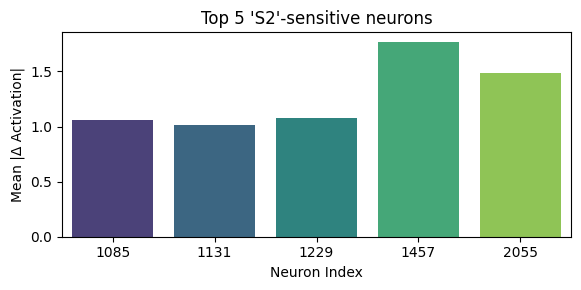

In [22]:
from src.observational.neuron import mlp_neurons_by_abs_diff

# Build position dictionaries for the corrupted prompts
position_dicts_corr = build_position_dicts_from_token_ids(corrupted_tokens)

threshold = 1.0
top_k = 5  # Number of top neurons to select per position

mlp_diff_df = mlp_neurons_by_abs_diff(
    model=model,
    clean_cache=cache,
    corr_cache=corrupted_cache,
    clean_position_dicts=position_dicts,
    corr_position_dicts=position_dicts_corr,
    layer=0,
    position_keys=["S1", "IO", "S2"],
    threshold=threshold,
)

def classify_top_position_sensitive_neurons(diff_df: pd.DataFrame, top_k=top_k):
    """
    From a DataFrame of neuron-wise activation diffs by position (e.g., S1, IO, S2),
    classify neurons into position-sensitive groups and plot their scores.

    Args:
        diff_df (pd.DataFrame): [neuron, position] mean abs activation difference
        top_k (int): How many top neurons to select per position
    """
    # Determine the most sensitive position for each neuron
    pos_keys = diff_df.columns.tolist()
    neuron_class = diff_df.idxmax(axis=1)  # gives "S1", "IO", etc. per neuron
    neuron_maxval = diff_df.max(axis=1)

    df_classified = pd.DataFrame({
        "neuron": diff_df.index,
        "position": neuron_class,
        "max_diff": neuron_maxval
    })

    # Select top-k neurons per class
    top_neurons_by_pos = {}
    for pos in pos_keys:
        df_pos = df_classified[df_classified["position"] == pos]
        top_k_neurons = df_pos.sort_values("max_diff", ascending=False).head(top_k)
        top_neurons_by_pos[pos] = top_k_neurons

    # Print and plot per position
    for pos, df_top in top_neurons_by_pos.items():
        if df_top.empty:
            print(f"No neurons found for position '{pos}'")
            continue
        print(f"\nTop {top_k} neurons for position '{pos}':")
        print(df_top[["neuron", "max_diff"]].round(4))

        plt.figure(figsize=(6, 3))
        sns.barplot(x="neuron", y="max_diff", data=df_top, palette="viridis")
        plt.title(f"Top {top_k} '{pos}'-sensitive neurons")
        plt.ylabel("Mean |Δ Activation|")
        plt.xlabel("Neuron Index")
        plt.tight_layout()
        plt.show()

    return top_neurons_by_pos

# Run the classification & plotting
top_k_neurons_by_position = classify_top_position_sensitive_neurons(mlp_diff_df, top_k=top_k)

#### MLP Neuron Firing

We can now plot the activation of a single MLP neuron for all prompts across all token positions.
I want to note that the IOI task does not involve other MLPs in the circuit besides MLP0 which was considered an extension of the token embedding layer. In the mech-interp literature this assumption was tested and discussed (first in the IOI paper, Appendix J and the Copy Suppression paper by [McDougall et al., 2023](https://arxiv.org/pdf/2310.04625), Appendix I)

Function details: 

<span style='color: yellow'>plot_neuron_activation</span> takes in the `model`, `cache`, `tokenizer` and `tokens`

- <span style="background-color: blue">**layer**</span>: The layer of the MLP
- <span style="background-color: blue">**neuron_idx**</span>: The neuron from the MLP output activation (shape [`batch`, `pos`, `d_mlp`])
- <span style="background-color: blue">**prompt_idx**</span>: The id of the prompt for when we loop through all prompts
- <span style="background-color: blue">**target_roles**</span>: Specify the word from the prompt that we want to highlight in red, useful if we want to keep track of a word that appears in multiple prompts
- <span style="background-color: blue">**position_dict**</span>: The word to token position dictionary used to assign labels on the scatter plot

Token ' Mary' at position 4 labeled as IO. Activation: 3.4695
Token ' John' at position 2 labeled as S1. Activation: -0.1537
Token ' John' at position 10 labeled as S2. Activation: -0.1585


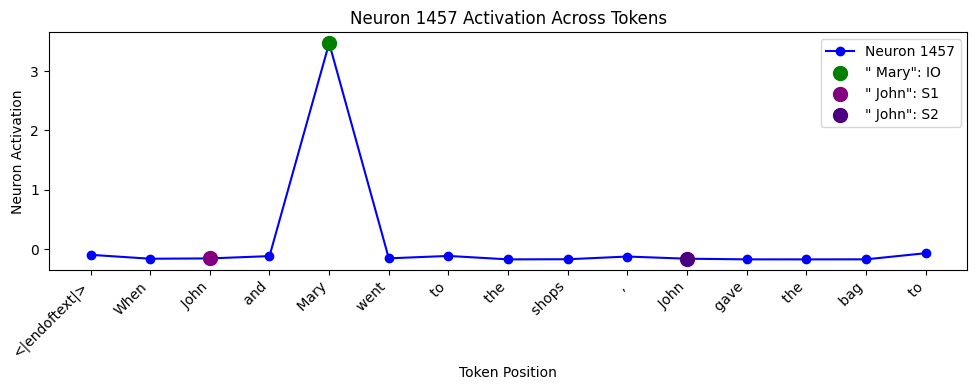

Token ' Mary' at position 4 labeled as IO. Activation: -0.1570
Token ' John' at position 2 labeled as S1. Activation: 2.8177
Token ' John' at position 10 labeled as S2. Activation: 2.8118


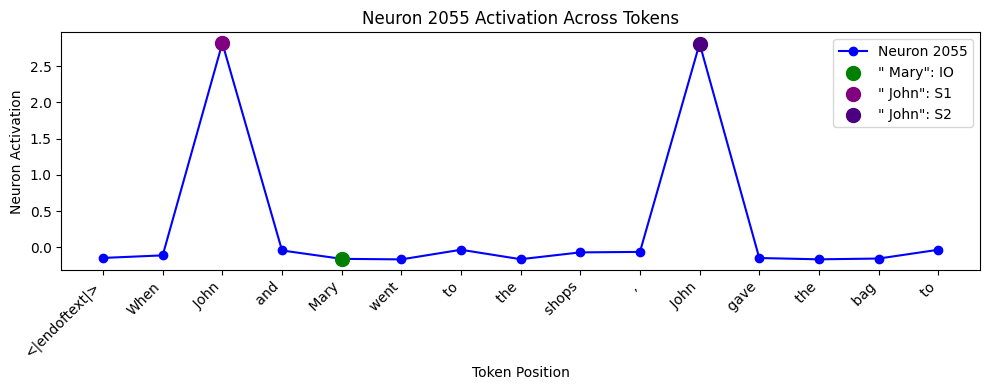

Token ' Mary' at position 4 labeled as IO. Activation: 1.5106
Token ' John' at position 2 labeled as S1. Activation: 2.7561
Token ' John' at position 10 labeled as S2. Activation: 2.1061


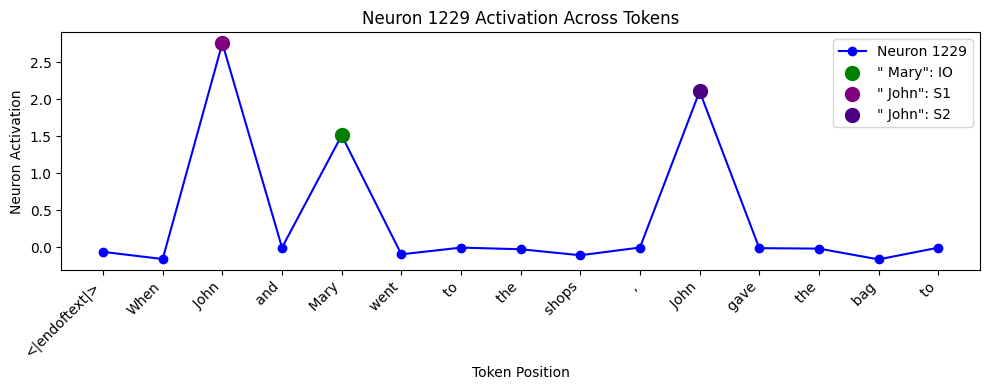

Token ' Mary' at position 4 labeled as IO. Activation: -0.0419
Token ' John' at position 2 labeled as S1. Activation: 1.3258
Token ' John' at position 10 labeled as S2. Activation: 1.1279


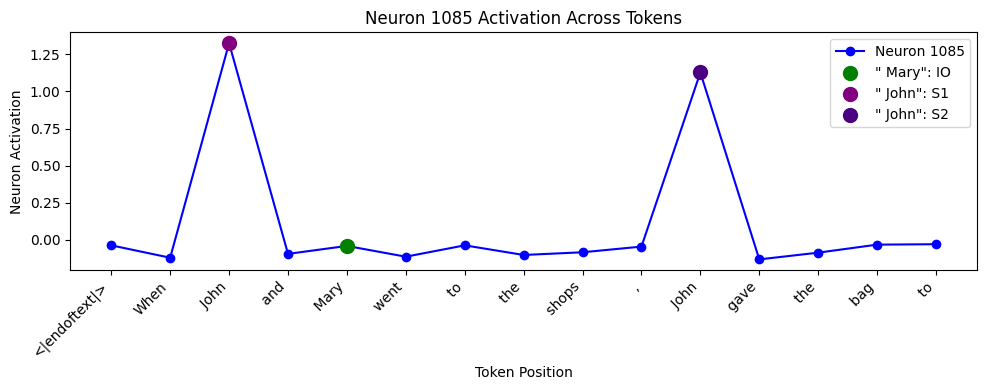

Token ' Mary' at position 4 labeled as IO. Activation: -0.0974
Token ' John' at position 2 labeled as S1. Activation: -0.1303
Token ' John' at position 10 labeled as S2. Activation: -0.0915


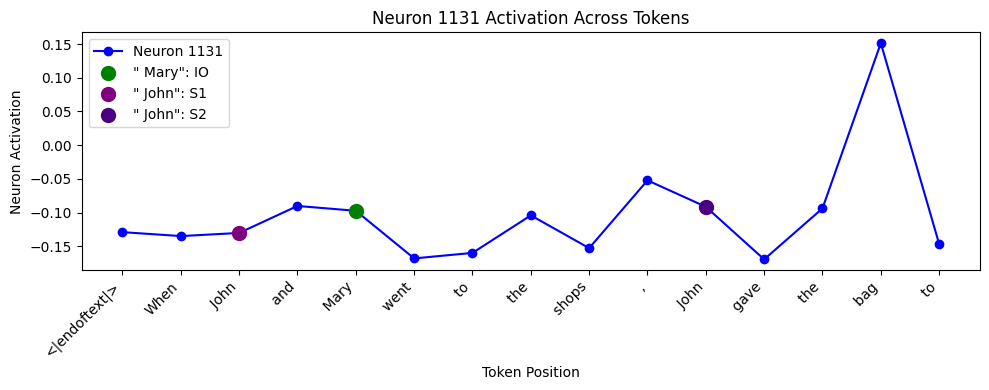

In [23]:
from src.observational.neuron import plot_neuron_activation

# Plot neuron activation for the top neuron by max diff in activations across all positions in IOI prompts
for pos, df_top in top_k_neurons_by_position.items():
    if df_top.empty:
        continue  # Skip if no neurons for this position
    for id in range(len(prompts)):
        for neuron_idx in top_k_neurons_by_position[pos]['neuron'].values[range(len(top_k_neurons_by_position[pos]))].tolist():
            plot_neuron_activation(
                model=model, 
                clean_cache=cache, 
                tokenizer=model.tokenizer, 
                clean_tokens=tokens,
                layer=0,  
                neuron_idx=neuron_idx, 
                prompt_idx=id,           
                target_roles=['IO', 'S1', 'S2'],  # semantic labels instead of tokens
                position_dict=position_dicts[0]
            )
        if id == 0:
            break

#### Zero Ablation

Now we may want to perform an ablation on the neurons that activate most on the S2 token position, such that from our previous figures their activation is corrupted, i.e. either replaced with zero (Zero Ablation) or with the activation on the corrupted prompt (Activation Patching). We then record the effect of this corruption by measuring the change in the original logit difference.

<details><summary>Implementation details</summary>

We need a hook function that identifies the activation of a specific token position, i.e. we index by the second dimension of the tensor and then rewrites that activation with zero. Optionally we can replace by the mean value of across all positions, such that we do not break computation (this argument is a little bit more involved, and I remember seeing in the [glossary](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=luqfyzyEYseMSYnKe-49MEJL)] that "if that activation is always in the range [100, 102], then setting it to zero may break everything on all tasks)". 

After we define a `fwd_hook = [hook_ablate_mlp_neuron_pos()]` and pass in arguments for the layer, neuron (in range $\mathbf{d_mlp}$ = 3072 in GPT-2 Small), token position and whether to ablate by the mean value or zero we pass in the hook to the model in the `model.run_with_hooks(tokens, fwd_hooks=fwd_hook)` function and finally take the logit difference from the resulted logits.

</details>

In [24]:
from src.patching.act_patching import hook_ablate_mlp_neuron_pos, hook_set_mlp_neuron_pos, hook_save_mlp_output

model.reset_hooks()

# Get clean logits
true_logit_diff = logits_to_ave_logit_diff(original_logits, answer_tokens)
print(f"Original logit difference: {true_logit_diff:.4f}")
# Setup
pos_s2 = position_dicts[0]['S2'].item()
logit_diff_deltas = []

# Loop over top neurons
for neuron in top_k_neurons_by_position['S2']['neuron'].to_list():
    fwd_hooks = [hook_ablate_mlp_neuron_pos(layer=0, neuron=neuron, pos=pos_s2, means=None)]
    
    abl_logits = model.run_with_hooks(tokens, fwd_hooks=fwd_hooks, return_type="logits")

    abl_logit_diff = logits_to_ave_logit_diff(abl_logits, answer_tokens)

    delta = (true_logit_diff - abl_logit_diff).item()
    logit_diff_deltas.append(delta)

    # Print the logit difference for the ablated neuron
    print(f"Ablated Neuron {neuron}: logit diff = {abl_logit_diff:.4f}, Δ logit diff (orig - patched) = {delta:.4f}")

Original logit difference: 3.5519
Ablated Neuron 1457: logit diff = 3.4952, Δ logit diff (orig - patched) = 0.0567
Ablated Neuron 2055: logit diff = 3.5241, Δ logit diff (orig - patched) = 0.0278
Ablated Neuron 1229: logit diff = 3.5702, Δ logit diff (orig - patched) = -0.0184
Ablated Neuron 1085: logit diff = 3.5642, Δ logit diff (orig - patched) = -0.0123
Ablated Neuron 1131: logit diff = 3.5415, Δ logit diff (orig - patched) = 0.0104


#### Patching the Activation from the Corrupt Distribution

In [25]:
model.reset_hooks()

pos = position_dicts[0]["S2"].item()
mlp_0_out_arr = []

fwd_hooks = [hook_save_mlp_output(model=model, layer=0, save_arr=mlp_0_out_arr, include_bias=False)]
_ = model.run_with_hooks(corrupted_tokens, fwd_hooks=fwd_hooks)

print(f"Original logit difference: {true_logit_diff:.4f}")
model.reset_hooks()
for neuron in top_k_neurons_by_position['S2']['neuron'].to_list():
    # Create hook
    fwd_hooks = [hook_set_mlp_neuron_pos(layer=0, neuron=neuron, pos=pos, new_input=mlp_0_out_arr)]

    # Run patched model
    abl_logits = model.run_with_hooks(tokens, fwd_hooks=fwd_hooks, return_type="logits")
    abl_logit_diff = logits_to_ave_logit_diff(abl_logits, answer_tokens)
    delta = (true_logit_diff - abl_logit_diff).item()
    logit_diff_deltas.append(delta)
    # Print the logit difference for the patched neuron
    print(f"Patched Neuron {neuron}: logit diff = {abl_logit_diff:.4f}, Δ logit diff (orig - patched) = {delta:.4f}")

Original logit difference: 3.5519
Patched Neuron 1457: logit diff = 3.3154, Δ logit diff (orig - patched) = 0.2364
Patched Neuron 2055: logit diff = 3.4865, Δ logit diff (orig - patched) = 0.0654
Patched Neuron 1229: logit diff = 3.5436, Δ logit diff (orig - patched) = 0.0083
Patched Neuron 1085: logit diff = 3.5606, Δ logit diff (orig - patched) = -0.0088
Patched Neuron 1131: logit diff = 3.5534, Δ logit diff (orig - patched) = -0.0015


### Backup Name Movers

In the section "Exploring Anomalies" from the [Exploratory Analysis Demo notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=OBeDLiycy2nZ), the Backup Name Movers are investigated, as part of the late heads. They form when the Name Movers are ablated (this can be approached in two ways: ablating with *zero* and with the *mean* of the other heads) as helpers to continue the task that the Name Movers were previously doing, i.e. restore the original logit difference.

<details> <summary>Implementation Details</summary> 

Ablating heads is really easy in TransformerLens! We can just define a hook on the `z` activation in the relevant attention layer (recall, `z` is the mixed values, and comes immediately before multiplying by the output weights $W_O$). `z` has a head_index axis, so we can set the component for the relevant head and for position -1 to zero, and return it. (Technically we could just edit in place without returning it, but by convention we always return an edited activation). 

We now want to compare all internal activations with a hook, which is hard to do with the nice `run_with_hooks` API. So we can directly access the hook on the `z` activation with `model.blocks[layer].attn.hook_z` and call its `add_hook` method. This adds in the hook to the *global state* of the model. We can now use `run_with_cache`, and don't need to care about the global state, `because run_with_cache` internally adds a bunch of caching hooks, and then removes all hooks after the run, *including* the previously added ablation hook. This can be disabled with the `reset_hooks_end` flag, but here it's useful! 

</details>

In [26]:
from src.observational.direct_logit_attribution import direct_logit_attribution

per_head_logit_diffs, labels = direct_logit_attribution(model, prompts, cache, answer_tokens, decomposition="attention_heads")

top_name_mover = per_head_logit_diffs.flatten().argmax().item()
top_name_mover_layer = top_name_mover // model.cfg.n_heads
top_name_mover_head = top_name_mover % model.cfg.n_heads
print(f"Top Name Mover to ablate: L{top_name_mover_layer}H{top_name_mover_head}")

def ablate_top_head_hook(z: Float[torch.Tensor, "batch pos head_index d_head"], hook):
    z[:, -1, top_name_mover_head, :] = 0
    return z

# Adds a hook into global model state
model.blocks[top_name_mover_layer].attn.hook_z.add_hook(ablate_top_head_hook)
# Runs the model, temporarily adds caching hooks and then removes *all* hooks after running, including the ablation hook.
ablated_logits, ablated_cache = model.run_with_cache(clean_tokens)
print(f"Original logit diff: {clean_logit_diff}")
print(
    f"Post ablation logit diff: {logits_to_ave_logit_diff(ablated_logits, answer_tokens).item():.2f}"
)
print(
    f"Direct Logit Attribution of top name mover head: {per_head_logit_diffs.flatten()[top_name_mover].item():.2f}"
)
print(
    f"Naive prediction of post ablation logit diff: {clean_logit_diff - per_head_logit_diffs.flatten()[top_name_mover].item()}"
)

Tried to stack head results when they weren't cached. Computing head results now
Top Name Mover to ablate: L9H9
Original logit diff: tensor([ 3.3367, -3.2016, -2.7095,  3.7975, -1.7204,  5.2812, -2.6008,  5.7674],
       device='cuda:0')
Post ablation logit diff: 2.92
Direct Logit Attribution of top name mover head: 2.99
Naive prediction of post ablation logit diff: tensor([ 0.3513, -6.1871, -5.6949,  0.8120, -4.7059,  2.2957, -5.5862,  2.7820],
       device='cuda:0')


In [27]:
from src.observational.direct_logit_attribution import residual_stack_to_logit_diff

answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

per_head_ablated_residual, labels = ablated_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_ablated_logit_diffs = residual_stack_to_logit_diff(
    per_head_ablated_residual, ablated_cache, logit_diff_directions, prompts
)
per_head_ablated_logit_diffs = per_head_ablated_logit_diffs.reshape(
    model.cfg.n_layers, model.cfg.n_heads
)
imshow(
    torch.stack([
        per_head_logit_diffs,
        per_head_ablated_logit_diffs,
        per_head_ablated_logit_diffs - per_head_logit_diffs
    ]),
    title="Direct logit contribution by head, pre / post ablation",
    labels={"x":"Head", "y":"Layer"},
    facet_col=0,
    facet_labels=["No ablation", "9.9 is ablated", "Change in head contribution post-ablation"],
)
scatter(
    y=per_head_logit_diffs.flatten(),
    x=per_head_ablated_logit_diffs.flatten(),
    hover_name=head_labels,
    range_x=(-3, 3),
    range_y=(-3, 3),
    xaxis="Ablated",
    yaxis="Original",
    title="Original vs Post-Ablation Direct Logit Attribution of Heads",
)

Answer residual directions shape: torch.Size([8, 2, 768])
Logit difference directions shape: torch.Size([8, 768])


How can we interpet these plots?

1. The first plot indicates that Backup Name Movers form after ablating L9H9. They are: L8H10, L10H6, L10H10.

2. What we measure in the second plot is the effect of ablating the top Name Mover in terms of logit attribution. So this effect is actually how the direct logit attribution of each individual head is modified because of the ablation of the top Name Mover. We see that ablating L9H9 actually decreases the negaive effect of Negative Name Movers, such as L10H7 and L11H2. 

If there is evidence on the existance of Backup Head Movers, looking at the Original vs Post-Ablation Direct Logit Attribution of Heads is useful to determine by how much these class of heads write in the same direction as the Name Movers, so it's not just a form of validating them as part of the circuit. 

One natural hypothesis is that this is because the final LayerNorm scaling has changed, which can scale up or down the final residual stream. This is slightly true, and we can see that the typical head is a bit off from the x=y line. But the average LN scaling ratio is 1.05, and this should uniformly change all heads by the same factor, so this can't be sufficient.

In [28]:
print(
    "Average LN scaling ratio:",
    round(
        (
            cache["ln_final.hook_scale"][:, -1]
            / ablated_cache["ln_final.hook_scale"][:, -1]
        )
        .mean()
        .item(),
        3,
    ),
)
print(
    "Ablation LN scale",
    ablated_cache["ln_final.hook_scale"][:, -1].detach().cpu().round(decimals=2),
)
print(
    "Original LN scale",
    cache["ln_final.hook_scale"][:, -1].detach().cpu().round(decimals=2),
)

Average LN scaling ratio: 1.042
Ablation LN scale tensor([[18.5200],
        [17.4700],
        [17.8200],
        [17.5100],
        [17.2600],
        [18.2500],
        [16.1800],
        [17.4300]])
Original LN scale tensor([[19.5700],
        [18.3500],
        [18.2900],
        [18.6800],
        [17.4900],
        [18.8700],
        [16.4200],
        [18.6800]])


## Zooming out

Returning to Attention heads, we can now visualize attention patterns of different important heads; in terms of their patched attention pattern (QK circuit), their value vectors or their output vectors. We take the top 10 heads by output patching (in absolute value) and split it into early, middle and late.  

In [29]:
from src.observational.plot_head import show_attention_patterns_circuitsvis

top_k = 10
top_heads_by_output_patch = torch.topk(
    patched_head_z_diff.abs().flatten(), k=top_k
).indices
first_mid_layer = 7
first_late_layer = 9
early_heads = top_heads_by_output_patch[
    top_heads_by_output_patch < model.cfg.n_heads * first_mid_layer
]
mid_heads = top_heads_by_output_patch[
    torch.logical_and(
        model.cfg.n_heads * first_mid_layer <= top_heads_by_output_patch,
        top_heads_by_output_patch < model.cfg.n_heads * first_late_layer,
    )
]
late_heads = top_heads_by_output_patch[
    model.cfg.n_heads * first_late_layer <= top_heads_by_output_patch
]

early = show_attention_patterns_circuitsvis(
    model, early_heads, cache, tokens[0], title=f"Top Early Heads"
)
mid = show_attention_patterns_circuitsvis(
    model, mid_heads, cache, tokens[0], title=f"Top Middle Heads"
)
late = show_attention_patterns_circuitsvis(
    model, late_heads, cache, tokens[0], title=f"Top Late Heads"
)

HTML(early + mid + late)

In [30]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Path Patching

Path Patching is an algorithm that can be used to isolate the direct effect of a path (or in circuit terms; edge) (input -> **head** -> output logits) from indirect effects (input -> MLP -> **head 1** -> head 2 -> output logits) from other components in the Transformer. It was introduced in [Interpretability in the Wild: A Circuit for Indirect Object Identification in GPT-2 Small](https://arxiv.org/pdf/2211.00593), Wang et al. (2022) and and as far as I know there are many implementation of Path Patching, [first](https://colab.research.google.com/drive/15CJ1WAf8AWm6emI3t2nVfnO85-hxwyJU#scrollTo=vWnh6D5GDmL2), [second](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=teSb1k5Ul6mS) by Callum McDougall, which I freely used here, and the [EasyTransformer implementation](https://github.com/redwoodresearch/Easy-Transformer/blob/main/easy_transformer/ioi_utils.py) (the repo companion of the IOI paper; merged into the `ioi/edge_patching` [branch](https://github.com/TransformerLensOrg/TransformerLens/blob/ioi/edge_patching/ioi_utils.py#L941) of TransformerLens). 

![image.png](figures/Path_Patching.png)

1In the IOI paper Path Patching is used as follows: 

- start from the Name Mover Heads with the highest direct effect on logits (from Logit Difference)
- work backwards; which Head influences the Name Mover Heads, then which heads influences those heads and so on
    - note that Path Patching supports receiver heads for Attention Q/K/V as `attn.hook_q/k/v_input`. For the rest of available receiver heads see below the documentation for the <span style='color: yellow'>path_patch</span> function.
- it is important for patching at specific position from the prompt. the question can be framed as: Which Heads influence the Name Movers at position `END`?  
    - the implementation `src.patching.path_patching_ioi` supports patching at specific positions, but for this demo we use a generic version of path patching, usable on-the-fly with any prompt that satisfies our setup criteria.

`!` I will not document how every element (Attention head) in the IOI circuit is found via Path Patching, as it is already done in the ARENA notebook extensively. I will only apply Path Patching to every class of Attention head in the circuit from the taxonomy provided by the authors, which is defined in the Circuit Validation section below, so this section can be skimmed up until the last code blocks where I demonstrate how to perform the Path Patching on individual neurons from MLP 0 that we found by absolute diff in activation at certain position and we attempt to test on assumption that they might provide later attention heads, especially from earlier layers that are performing primitive sentence-level functionalities.

First setup the patching metric and collect caches from clean and corrupt runs:

In [10]:
def _pp_metric_noising(
        logits: Float[Tensor, "batch seq d_vocab"],
        clean_logit_diff: float,
        corrupted_logit_diff: float,
        answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    ) -> float:
        '''
        We calibrate this so that the value is 0 when performance isn't harmed (i.e. same as IOI dataset),
        and -1 when performance has been destroyed (i.e. is same as ABC dataset).
        '''
        patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
        return ((patched_logit_diff - clean_logit_diff) / (clean_logit_diff - corrupted_logit_diff)).item()

def generate_data_and_caches(verbose: bool = False):

    model.reset_hooks(including_permanent=True)

    abc_logits_original, abc_cache = model.run_with_cache(clean_tokens.long())
    cba_logits_original, cba_cache = model.run_with_cache(corrupted_tokens.long())

    abc_average_logit_diff = logits_to_ave_logit_diff(abc_logits_original, answer_tokens).item()
    cba_average_logit_diff = logits_to_ave_logit_diff(cba_logits_original, answer_tokens).item()

    if verbose:
        print(f"Average logit diff (ABC dataset): {abc_average_logit_diff:.4f}")
        print(f"Average logit diff (CBA dataset): {cba_average_logit_diff:.4f}")

    pp_metric_noising = partial(
        _pp_metric_noising,
        clean_logit_diff=abc_average_logit_diff,
        corrupted_logit_diff=cba_average_logit_diff,
        answer_tokens=answer_tokens,
    )

    return abc_cache, cba_cache, pp_metric_noising

abc_cache, cba_cache, pp_metric_noising = generate_data_and_caches(verbose=True)

Average logit diff (ABC dataset): 3.5519
Average logit diff (CBA dataset): -3.5519


Function details: 

<span style='color: yellow'>path_patch</span>: 

- <span style="background-color: blue">**model**</span>: 
- <span style="background-color: blue">**orig_input**</span>: The clean tokens
- <span style="background-color: blue">**new_input**</span>:  The corrupt tokens
- <span style="background-color: blue">**receiver_nodes**</span>: The things you can path patch into (receivers) are: 
    - <span style="background-color: hsl(0 100% 20%);">**resid_pre**</span>, <span style="background-color: hsl(0 100% 20%);">**resid_mid**</span>, <span style="background-color: hsl(0 100% 20%);">**resid_post**</span>
    - Attention head inputs: <span style="background-color: hsl(0 100% 20%);">**q**</span>, <span style="background-color: hsl(0 100% 20%);">**k**</span>, <span style="background-color: hsl(0 100% 20%);">**v**</span>, or q_input, k_input, v_input
    - MLP input: <span style="background-color: hsl(0 100% 20%);">**pre**</span>

- <span style="background-color: blue">**sender_nodes**</span>: The things you can patch from (senders) are:

    - <span style="background-color: hsl(0 100% 20%);">**resid_pre**</span>, <span style="background-color: hsl(0 100% 20%);">**resid_mid**</span>, <span style="background-color: hsl(0 100% 20%);">**resid_post**</span>
    - Attention head output, by head <span style="background-color: hsl(0 100% 20%);">**z**</span> or over all heads <span style="background-color: hsl(0 100% 20%);">**attn_out**</span>
    - MLP output, by neuron <span style="background-color: hsl(0 100% 20%);">**post**</span> or over all neurons <span style="background-color: hsl(0 100% 20%);">**mlp_out**</span>

- <span style="background-color: blue">**seq_pos**</span>:
- <span style="background-color: blue">**patching_metric**</span>:
- <span style="background-color: blue">**direct_includes_mlp**</span>: Whether or not to include MLPs as direct paths.

    -  If <span style="background-color: hsl(0 100% 20%);">**False**</span>: This version is simpler. It doesn't treat MLPs as direct, so a "direct path" is just the skip connection from sender output -> receiver input. The algorithm works as follows:
        1. Gather all activations on orig and new distributions.
        2. Forward pass on orig input, with the following intervention:
            `orig_receiver_input <- orig_receiver_input + sum_over_senders {new_sender_output - orig_sender_output}`

    -  If <span style="background-color: hsl(0 100% 20%);">**True**</span>: This version is more complex. Step (2) can't happen in one forward pass, because the new value we patch the receivers to is a function of the MLP's nonlinear jiggery pokery. We split step (2) into 2 steps, one where we patch senders & compute what we'll be patching into the receivers, and one where we actually perform the receiver patching. The algorithm works as follows:
        1. Gather all activations on orig and new distributions.
        2. Run model on orig with sender nodes patched from new and all other nodes frozen. Cache the receiver nodes.
        3. Run model on orig with receiver nodes patched from previously cached values.


### 1️⃣ Patching from attention head -> final residual stream value

In [11]:
from src.patching.path_patching import path_patch, IterNode, Node

results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode('z'),
    receiver_nodes=Node('resid_post', 11), # this is the final residual stream
    patching_metric=pp_metric_noising,
    direct_includes_mlps=True,
    verbose=True
)

results_direct = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode('z'),
    receiver_nodes=Node('resid_post', 11), # this is the final residual stream
    patching_metric=pp_metric_noising,
    direct_includes_mlps=True,
    verbose=True
)

imshow(
    torch.stack([results['z'], results_direct['z']]),
    facet_col=0, facet_labels=["Direct path includes MLPs", "Direct path is just skip connections"],
    title="Each attention head's direct effect on logit difference",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # border=True,
    width=950,
    # margin={"r": 100, "l": 100}
)

Patching over 'z':   0%|          | 0/144 [00:00<?, ?it/s]

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 65.34it/s]


results['z'].shape = (layer=12, head=12)
-- path patch z -> Node(blocks.11.hook_resid_post) -> logits --


Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 65.84it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> Node(blocks.11.hook_resid_post) -> logits --


In [12]:
NAME_MOVERS = [(9, 9), (9, 6), (10, 0)]

results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=[Node("z", layer, head=head) for layer, head in NAME_MOVERS],
    receiver_nodes=Node("resid_post", 11), # This is final residual stream
    patching_metric=pp_metric_noising,
)

print(results)

--- path patch [Node(blocks.9.attn.hook_z, head=9), Node(blocks.9.attn.hook_z, head=6), Node(blocks.10.attn.hook_z, head=0)] -> Node(blocks.11.hook_resid_post) --> logits ---
-1.4769585132598877


In [13]:
NEGATIVE_NAME_MOVERS = [(10, 7), (11, 10)]

results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=[Node("z", layer, head=head) for layer, head in NEGATIVE_NAME_MOVERS],
    receiver_nodes=Node("resid_post", 11), # This is final residual stream
    patching_metric=pp_metric_noising,
)

print(results)

--- path patch [Node(blocks.10.attn.hook_z, head=7), Node(blocks.11.attn.hook_z, head=10)] -> Node(blocks.11.hook_resid_post) --> logits ---
0.8023388385772705


### 2️⃣ Patching from residual stream -> final residual stream value (for each sequence position)

In [ ]:
results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode(["resid_pre", "attn_out", "mlp_out"], seq_pos="each"),
    receiver_nodes=Node("resid_post", 11),
    patching_metric=pp_metric_noising,
    direct_includes_mlps=False, # gives similar results to direct_includes_mlps=True
    verbose=True,
)

results_stacked = torch.stack([
    results.T for results in results.values()
])

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

imshow(
    results_stacked,
    facet_col=0,
    facet_labels=['resid_pre', 'attn_out', 'mlp_out'],
    title="Results of denoising patching at residual stream",
    labels={"x": "Sequence position", "y": "Layer", "color": "Logit diff variation"},
    x=labels,
    # xaxis_tickangle=45,
    width=1300,
    # margin={"r": 100, "l": 100},
    # border=True,
)

Patching over 'resid_pre':   0%|          | 0/540 [00:00<?, ?it/s]

Patching over 'mlp_out': 100%|██████████| 540/540 [00:04<00:00, 118.50it/s]  

results['resid_pre'].shape = (seq_pos=15, layer=12)
-- path patch resid_pre -> Node(blocks.11.hook_resid_post) -> logits --
results['attn_out'].shape = (seq_pos=15, layer=12)
-- path patch attn_out -> Node(blocks.11.hook_resid_post) -> logits --
results['mlp_out'].shape = (seq_pos=15, layer=12)
-- path patch mlp_out -> Node(blocks.11.hook_resid_post) -> logits --


### 3️⃣ Patching from head to head

In [16]:
results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("q", layer, head=head) for layer, head in NAME_MOVERS],
    patching_metric=pp_metric_noising,
    verbose=True,
)

imshow(
    results['z'] * 100,
    title="Direct effect on Name Mover Heads' queries",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # coloraxis=dict(colorbar_ticksuffix = "%"),
    # border=True,
    width=700,
)

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 65.12it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.9.attn.hook_q, head=9), Node(blocks.9.attn.hook_q, head=6), Node(blocks.10.attn.hook_q, head=0)] -> logits --


In [17]:
results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("q", layer, head=head) for layer, head in NEGATIVE_NAME_MOVERS],
    patching_metric=pp_metric_noising,
    verbose=True,
)

imshow(
    results['z'] * 100,
    title="Direct effect on Negative Name Mover Heads' queries",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # coloraxis=dict(colorbar_ticksuffix = "%"),
    # border=True,
    width=700,
)

Patching over 'z':   0%|          | 0/144 [00:00<?, ?it/s]

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 64.30it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.10.attn.hook_q, head=7), Node(blocks.11.attn.hook_q, head=10)] -> logits --


In [18]:
S_INHIBITION_HEADS = [(7, 3), (7, 9), (8, 6), (8, 10)]

results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("v", layer, head=head) for layer, head in S_INHIBITION_HEADS], 
    patching_metric=pp_metric_noising,
    verbose=True,
)

imshow(
    results['z'] * 100,
    title="Direct effect on S-Inhibition Heads' values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # coloraxis=dict(colorbar_ticksuffix = "%"),
    # border=True,
    width=700,
)

Patching over 'z':   0%|          | 0/144 [00:00<?, ?it/s]

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 65.00it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.7.attn.hook_v, head=3), Node(blocks.7.attn.hook_v, head=9), Node(blocks.8.attn.hook_v, head=6), Node(blocks.8.attn.hook_v, head=10)] -> logits --


In [19]:
results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("k", layer, head=head) for layer, head in S_INHIBITION_HEADS], 
    patching_metric=pp_metric_noising,
    verbose=True,
)

imshow(
    results['z'] * 100,
    title="Direct effect on S-Inhibition Heads' keys",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # coloraxis=dict(colorbar_ticksuffix = "%"),
    # border=True,
    width=700,
)

Patching over 'z':   0%|          | 0/144 [00:00<?, ?it/s]

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 64.48it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.7.attn.hook_k, head=3), Node(blocks.7.attn.hook_k, head=9), Node(blocks.8.attn.hook_k, head=6), Node(blocks.8.attn.hook_k, head=10)] -> logits --


In [20]:
INDUCTION_HEADS = [(5, 5), (6, 9), (5, 8), (5, 9)]

results_ind_q = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("q", layer, head=head) for layer, head in INDUCTION_HEADS],
    patching_metric=pp_metric_noising,
    verbose=True,
)

results_ind_k = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("k", layer, head=head) for layer, head in INDUCTION_HEADS],
    patching_metric=pp_metric_noising,
    verbose=True,
)

results_ind_v = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode("z"),
    receiver_nodes=[Node("v", layer, head=head) for layer, head in INDUCTION_HEADS],
    patching_metric=pp_metric_noising,
    verbose=True,
)

imshow(
    torch.stack([results_ind_q['z'], results_ind_k['z'], results_ind_v['z']])[:, :8] * 100,
    facet_col=0, facet_labels=["Q", "K", "V"],
    title="Direct effect on Induction Heads' queries, keys, and values",
    labels={"x": "Head", "y": "Layer", "color": "Logit diff variation"},
    # coloraxis=dict(colorbar_ticksuffix = "%"),
    # border=True,
    width=700,
)

Patching over 'z':   0%|          | 0/144 [00:00<?, ?it/s]

Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 64.95it/s]


results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.5.attn.hook_q, head=5), Node(blocks.6.attn.hook_q, head=9), Node(blocks.5.attn.hook_q, head=8), Node(blocks.5.attn.hook_q, head=9)] -> logits --


Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 64.54it/s]


results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.5.attn.hook_k, head=5), Node(blocks.6.attn.hook_k, head=9), Node(blocks.5.attn.hook_k, head=8), Node(blocks.5.attn.hook_k, head=9)] -> logits --


Patching over 'z': 100%|██████████| 144/144 [00:02<00:00, 65.17it/s]

results['z'].shape = (layer=12, head=12)
-- path patch z -> [Node(blocks.5.attn.hook_v, head=5), Node(blocks.6.attn.hook_v, head=9), Node(blocks.5.attn.hook_v, head=8), Node(blocks.5.attn.hook_v, head=9)] -> logits --


Below are two examples for how we can perform customized path patching experiments based on our own findings from the neuron-level ablations section. Before, we found that neurons 2055 and 1457 preferentially attend to the S1/S2 and IO token position, respectively. We can test their causal importance by patching the paths e.g `MLP0.Neuron2055 -> DTH.{q/k/v}_input/pattern -> logits for DTH in DUPLICATE_TOKEN_HEADS` at token positions `S1/IO/S2`. See the code below for how we perform this loop and notice the `sender_nodes`, `receiver_nodes` and `seq_pos`. 

Original logit diff: 3.55189

--- path patch Node(blocks.0.mlp.hook_post, neuron=2055) -> [Node(blocks.0.attn.hook_q, head=1), Node(blocks.0.attn.hook_q, head=10), Node(blocks.3.attn.hook_q, head=0)] --> logits ---
Logit diff variation from neuron 2055 -> S-Inhibition Heads' q at position S1 -> logits: 0.0000%


--- path patch Node(blocks.0.mlp.hook_post, neuron=2055) -> [Node(blocks.0.attn.hook_q, head=1), Node(blocks.0.attn.hook_q, head=10), Node(blocks.3.attn.hook_q, head=0)] --> logits ---
Logit diff variation from neuron 2055 -> S-Inhibition Heads' q at position IO -> logits: 0.0000%


--- path patch Node(blocks.0.mlp.hook_post, neuron=2055) -> [Node(blocks.0.attn.hook_q, head=1), Node(blocks.0.attn.hook_q, head=10), Node(blocks.3.attn.hook_q, head=0)] --> logits ---
Logit diff variation from neuron 2055 -> S-Inhibition Heads' q at position S2 -> logits: -0.0165%


--- path patch Node(blocks.0.mlp.hook_post, neuron=2055) -> [Node(blocks.0.attn.hook_k, head=1), Node(blocks.0.attn.h

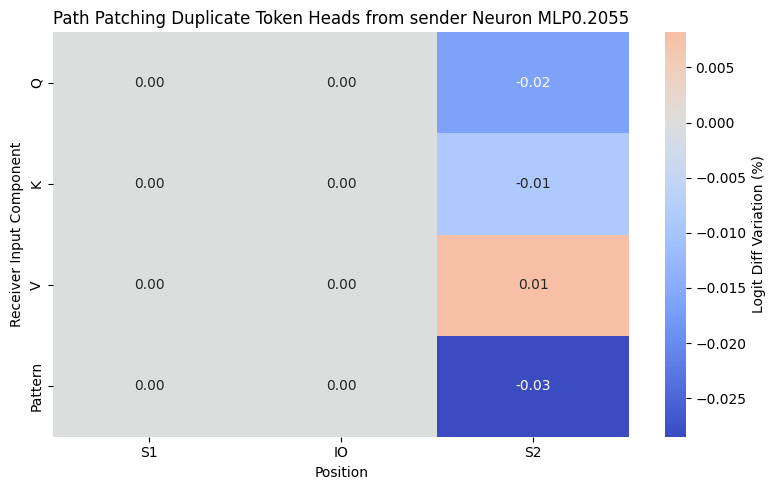

In [23]:
# neuron 2055 attends to S1/S2 tokens, neuron 1457 attends to IO token
neuron = 2055
# neuron = 1457

DUPLICATE_TOKEN_HEADS = [(0, 1), (0, 10), (3, 0)]
PREVIOUS_TOKEN_HEADS = [(2, 2), (4, 11)]
input_components = ['q', 'k', 'v', 'pattern']
heads_to_patch = DUPLICATE_TOKEN_HEADS

print(f"Original logit diff: {original_average_logit_diff:.5f}\n")
results_df = {}
for comp in input_components:
    for pos in ['S1', 'IO', 'S2']:
        results = path_patch(
            model,
            orig_input=clean_tokens,
            new_input=corrupted_tokens,
            # orig_cache=abc_cache,
            # new_cache=cba_cache,
            sender_nodes=Node('post', 0, neuron=neuron), # post (mlp_post), Node('post', layer=layer, neuron=neuron (in range d_mlp=3072)) 
            receiver_nodes=[Node(comp, layer, head=head) for layer, head in heads_to_patch], 
            patching_metric=pp_metric_noising,
            seq_pos=position_dicts[0][pos].item(),
            verbose=True,
            direct_includes_mlps=True,
            # apply_metric_to_cache=True,
        )
        # Save results in a DataFrame for plotting
        results_df[(comp, pos)] = results
        
        print(f"Logit diff variation from neuron {neuron} -> S-Inhibition Heads' {comp} at position {pos} -> logits: {results*100:.4f}%")
        print('\n')

df = pd.DataFrame(index=[comp.capitalize() for comp in input_components], columns=['S1', 'IO', 'S2'])

for (comp, pos), value in results_df.items():
    # Only fill if comp is in input_components
    if comp in input_components:
        df.loc[comp.capitalize(), pos] = value * 100  # convert to %
df = df.astype(float)

# Plot as a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={"label": "Logit Diff Variation (%)"})
plt.title(f"Path Patching {'Duplicate Token Heads'} from sender Neuron MLP0.{neuron}")
plt.xlabel("Position")
plt.ylabel("Receiver Input Component")
plt.tight_layout()
plt.show()

In [24]:
results = path_patch(
    model,
    orig_input=clean_tokens,
    new_input=corrupted_tokens,
    sender_nodes=IterNode(["mlp_out"], seq_pos='each'), 
    # receiver_nodes=Node("resid_post", 11),
    receiver_nodes=[Node('q', layer, head=head) for layer, head in DUPLICATE_TOKEN_HEADS], 
    patching_metric=pp_metric_noising,
    direct_includes_mlps=True, # gives similar results to direct_includes_mlps=True
    verbose=True,
    )

results_stacked = torch.stack([
    results.T for results in results.values()
])

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

imshow(
    results_stacked,
    facet_col=0,
    facet_labels=['mlp_out'],
    title="Results of Path Patching at residual stream",
    labels={"x": "Sequence position", "y": "Layer", "color": "Logit diff variation"},
    x=labels,
    # xaxis_tickangle=45,
    width=1300,
    # margin={"r": 100, "l": 100},
    # border=True,
)

Patching over 'mlp_out': 100%|██████████| 180/180 [00:02<00:00, 64.28it/s]

results['mlp_out'].shape = (seq_pos=15, layer=12)
-- path patch mlp_out -> [Node(blocks.0.attn.hook_q, head=1), Node(blocks.0.attn.hook_q, head=10), Node(blocks.3.attn.hook_q, head=0)] -> logits --


## Circuit Validation

This goes beyond the scope of the notebook where we constructed and used a prompt manually and investigated how GPT-2 Small performs the IOI task using a manually written prompt and token-to-position mapping. Now for the sake of completenss we perform the Circuit Validation step using the `ioi.ioi_dataset` script which has these functions already implemented in the `IOIDataset` class and the code below from the [Indirect Object Identification paper replication](https://colab.research.google.com/drive/1AA0wj2sHoZwtmy82WXORcZzk9urL1lVA#scrollTo=jHjUFdAPl6ma) by Callum McDougall for ARENA tutorials.

![IOI1](https://pbs.twimg.com/media/FghGkTAWAAAmkhm.jpg)

### Background: faithfulness, completeness, and minimality

The authors developed three criteria for validating their circuit explanations: faithfulness, completeness and minimality. They are defined as follows:

- **Faithful** = the circuit can perform as well as the whole model
- **Complete** = the circuit contains all nodes used to perform the task
- **Minimal** = the circuit doesn't contain nodes irrelevant to the task

If all three criteria are met, then the circuit is considered a reliable explanation for model behaviour.

A caveat is that faithfulness does not imply completeness, but that the reverse is true. Backup name mover heads illustrate this point. They are used in the task, and without understanding the role they play you'll have an incorrect model of reality (e.g. you'll think ablating the name mover heads would destroy performance, which turns out not to be true). So if you define a circuit that doesn't contain backup name mover heads then it will be faithful (the backup name mover heads won't be used) but not complete.

In the paper, the authors formalise these concepts. Faithfulness is equivalent to $|F(C) - F(M)|$ being small (where $C$ is our circuit, $M$ is the model, and $F$ is our performance metric function), and completeness is equivalent to $|F(C\backslash K) - F(M\backslash K)|$ being small **for any subset $K \subset C$** (including when $K$ is the empty set, showing that completeness implies faithfulness).

In order to perform the ablation, the authors used a mean-ablation on all nodes but the ones in the circuit at sequence position where they do not matter.

We define two dictionaries, one mapping head types to the heads in the model which are of that type, and the other mapping head types to the sequence positions which we won't be ablating for those types of head.

In [44]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    "induction": "S2",
    "duplicate token": "S2",
    "previous token": "S1+1",
}

To be clear, the things that we'll be mean-ablating are:

- Every head not in the `CIRCUIT` dict

- Every sequence position for the heads in `CIRCUIT` dict, except for the sequence positions given by the `SEQ_POS_TO_KEEP` dict

And we'll be mean-ablating by replacing a head's output with the mean output for abc_dataset, over all sentences with the same template as the sentence in the batch. You can access the templates for a dataset using the `dataset.groups` attribute, which returns a list of tensors (each one containing the indices of sequences in the batch sharing the same template).

In [45]:
from data.ioi.ioi_dataset import IOIDataset

def zip_and_tokenize_all_answers(model, clean_answers, corr_answers, device):
    all_answer_toks = []
    all_answers = []
    assert len(clean_answers) == len(corr_answers)
    for i in range(len(clean_answers)):
        all_answers.append(clean_answers[i])
        all_answers.append(corr_answers[i])

    for pair in all_answers:
        token_pair = []
        for ans in pair:
            token = model.to_single_token(ans)
            token_pair.append(token)
        
        all_answer_toks.append(token_pair)
    
    answer_tokens_ids = torch.tensor(all_answer_toks).to(device)
    return answer_tokens_ids, all_answers

N = 50
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=model.tokenizer,
    prepend_bos=False,
    seed=1,
    device=str(device)
)

abc_dataset = ioi_dataset.gen_flipped_prompts("ABB->XYZ, BAB->XYZ")

clean_prompts = []
for prompt in ioi_dataset.sentences:
    clean_prompts.append(" ".join(prompt.split(" ")[:-1]))

abc_prompts = []
for prompt in abc_dataset.sentences:
    abc_prompts.append(" ".join(prompt.split(" ")[:-1]))

clean_answers = []
for i in range(len(ioi_dataset)):
    clean_answer = " " + ioi_dataset.ioi_prompts[i]['IO']
    wrong_answer = " " + ioi_dataset.ioi_prompts[i]['S']
    answers = (clean_answer, wrong_answer)
    clean_answers.append(answers)

abc_answers = []
for i in range(len(abc_dataset)):
    clean_answer = " " + abc_dataset.ioi_prompts[i]['IO']
    wrong_answer = " " + abc_dataset.ioi_prompts[i]['S']
    answers = (clean_answer, wrong_answer)
    abc_answers.append(answers)

clean_answer_tokens = []
for answer in clean_answers:
    token_pair = []
    for ans in answer:
        # Convert the answer string to token and then to its corresponding token ID
        token = model.to_single_token(ans)
        token_pair.append(token)
    
    clean_answer_tokens.append(token_pair)
# Convert the list of token pairs to a PyTorch tensor
clean_answers_tokens_ids = torch.tensor(clean_answer_tokens).to(device)
# Both clean and correct prompts
all_answer_tok_ids, all_answer_strings = zip_and_tokenize_all_answers(model, clean_answers, abc_answers, device)

all_prompts_abc = list(zip(clean_prompts, abc_prompts))
all_prompts_strings_abc = [prompt for prompt_pair in all_prompts_abc for prompt in prompt_pair]

In [46]:
def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], ioi_dataset: IOIDataset = ioi_dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''
    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), ioi_dataset.word_idx["end"], ioi_dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), ioi_dataset.word_idx["end"], ioi_dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

model.reset_hooks(including_permanent=True)
ioi_logits_original, ioi_cache = model.run_with_cache(ioi_dataset.toks)

def get_heads_and_posns_to_keep(
    means_dataset: IOIDataset,
    model: HookedTransformer,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq head"]]:
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    z output which *shouldn'torch* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    heads_and_posns_to_keep = {}
    batch, seq, n_heads = len(means_dataset), means_dataset.max_len, model.cfg.n_heads

    for layer in range(model.cfg.n_layers):

        mask = torch.zeros(size=(batch, seq, n_heads))

        for (head_type, head_list) in circuit.items():
            seq_pos = seq_pos_to_keep[head_type]
            indices = means_dataset.word_idx[seq_pos]
            for (layer_idx, head_idx) in head_list:
                if layer_idx == layer:
                    mask[:, indices, head_idx] = 1

        heads_and_posns_to_keep[layer] = mask.bool()

    return heads_and_posns_to_keep


def hook_fn_mask_z(
    z: Float[Tensor, "batch seq head d_head"],
    hook: HookPoint,
    heads_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq head"]],
    means: Float[Tensor, "layer batch seq head d_head"],
) -> Float[Tensor, "batch seq head d_head"]:
    '''
    Hook function which masks the z output of a transformer head.

    heads_and_posns_to_keep
        Dict created with the get_heads_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean z values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, and add d_head=1 dimension so it broadcasts correctly
    mask_for_this_layer = heads_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(z.device)

    # Set z values to the mean
    z = torch.where(mask_for_this_layer, z, means[hook.layer()])

    return z


def compute_means_by_template(
    means_dataset: IOIDataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("z"),
    )
    # Create tensor to store means
    n_layers, n_heads, d_head = model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = torch.zeros(size=(n_layers, batch, seq_len, n_heads, d_head), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(model.cfg.n_layers):
        z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
        for template_group in means_dataset.groups:
            z_for_this_template = z_for_this_layer[template_group]
            z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
            means[layer, template_group] = z_means_for_this_template
            # means[layer, template_group] = 0 # Uncomment this line to zero ablate all heads on unimportant positions

    return means

def add_mean_ablation_hook(
    model: HookedTransformer,
    means_dataset: IOIDataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    return model

model = add_mean_ablation_hook(model, means_dataset=abc_dataset, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)

ioi_logits_minimal = model(ioi_dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal):.4f}")

Average logit difference (IOI dataset, using entire model): 3.0767
Average logit difference (IOI dataset, only using circuit): 2.6538


In [47]:
CIRCUIT

{'name mover': [(9, 9), (10, 0), (9, 6)],
 'backup name mover': [(10, 10),
  (10, 6),
  (10, 2),
  (10, 1),
  (11, 2),
  (9, 7),
  (9, 0),
  (11, 9)],
 'negative name mover': [(10, 7), (11, 10)],
 's2 inhibition': [(7, 3), (7, 9), (8, 6), (8, 10)],
 'induction': [(5, 5), (5, 8), (5, 9), (6, 9)],
 'duplicate token': [(0, 1), (0, 10), (3, 0)],
 'previous token': [(2, 2), (4, 11)]}

In [48]:
K_FOR_EACH_COMPONENT = {
    (9, 9): set(),
    (10, 0): {(9, 9)},
    (9, 6): {(9, 9), (10, 0)},
    (10, 7): {(11, 10)},
    (11, 10): {(10, 7)},
    (8, 10): {(7, 9), (8, 6), (7, 3)},
    (7, 9): {(8, 10), (8, 6), (7, 3)},
    (8, 6): {(7, 9), (8, 10), (7, 3)},
    (7, 3): {(7, 9), (8, 10), (8, 6)},
    (5, 5): {(5, 9), (6, 9), (5, 8)},
    (5, 9): {(11, 10), (10, 7)},
    (6, 9): {(5, 9), (5, 5), (5, 8)},
    (5, 8): {(11, 10), (10, 7)},
    (0, 1): {(0, 10), (3, 0)},
    (0, 10): {(0, 1), (3, 0)},
    (3, 0): {(0, 1), (0, 10)},
    (4, 11): {(2, 2)},
    (2, 2): {(4, 11)},
    (11, 2): {(9, 9), (10, 0), (9, 6)},
    (10, 6): {(9, 9), (10, 0), (9, 6), (11, 2)},
    (10, 10): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6)},
    (10, 2): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10)},
    (9, 7): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2)},
    (10, 1): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2), (9, 7)},
    (11, 9): {(9, 9), (10, 0), (9, 6), (9, 0)},
    (9, 0): {(9, 9), (10, 0), (9, 6), (11, 9)},
}

In [ ]:
from typing import Set
from tqdm import tqdm

def get_score(
    model: HookedTransformer,
    ioi_dataset: IOIDataset,
    abc_dataset: IOIDataset,
    K: Set[Tuple[int, int]],
    C: Dict[str, List[Tuple[int, int]]],
) -> float:
    '''
    Returns the value F(C \ K), where F is the logit diff, C is the
    core circuit, and K is the set of circuit components to remove.
    '''
    C_excl_K = {k: [head for head in v if head not in K] for k, v in C.items()}
    model = add_mean_ablation_hook(model, abc_dataset, C_excl_K, SEQ_POS_TO_KEEP)
    logits = model(ioi_dataset.toks.long())
    score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

    return score


def get_minimality_score(
    model: HookedTransformer,
    ioi_dataset: IOIDataset,
    abc_dataset: IOIDataset,
    v: Tuple[int, int],
    K: Set[Tuple[int, int]],
    C: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
) -> float:
    '''
    Returns the value | F(C \ K_union_v) - F(C | K) |, where F is
    the logit diff, C is the core circuit, K is the set of circuit
    components to remove, and v is a head (not in K).
    '''
    assert v not in K
    K_union_v = K | {v}
    C_excl_K_score = get_score(model, ioi_dataset, abc_dataset, K, C)
    C_excl_Kv_score = get_score(model, ioi_dataset, abc_dataset, K_union_v, C)

    return abs(C_excl_K_score - C_excl_Kv_score)


def get_all_minimality_scores(
    model: HookedTransformer,
    ioi_dataset: IOIDataset = ioi_dataset,
    abc_dataset: IOIDataset = abc_dataset,
    k_for_each_component: Dict = K_FOR_EACH_COMPONENT
) -> Dict[Tuple[int, int], float]:
    '''
    Returns dict of minimality scores for every head in the model (as
    a fraction of F(M), the logit diff of the full model).

    Warning - this resets all hooks at the end (including permanent).
    '''
    # Get full circuit score F(M), to divide minimality scores by
    model.reset_hooks(including_permanent=True)
    logits = model(ioi_dataset.toks.long())
    full_circuit_score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

    # Get all minimality scores, using the `get_minimality_score` function
    minimality_scores = {}
    for v, K in tqdm(k_for_each_component.items()):
        score = get_minimality_score(model, ioi_dataset, abc_dataset, v, K)
        minimality_scores[v] = score / full_circuit_score

    model.reset_hooks(including_permanent=True)

    return minimality_scores

In [ ]:
minimality_scores = get_all_minimality_scores(model)
print(minimality_scores)

100%|██████████| 26/26 [00:57<00:00,  2.21s/it]

{(9, 9): 0.1242749601209178, (10, 0): 0.06625526409696982, (9, 6): 0.07369894615384318, (10, 7): 0.326816450058448, (11, 10): 0.2768027921750596, (8, 10): 0.20072798455748653, (7, 9): 0.2142539386042302, (8, 6): 0.20101090615891112, (7, 3): 0.05797098290652932, (5, 5): 0.4097817567098953, (5, 9): 0.1418327600896887, (6, 9): 0.2174839505340523, (5, 8): 0.10136017020241177, (0, 1): 0.47825058593288383, (0, 10): 0.39680298977847883, (3, 0): 0.1318344532797712, (4, 11): 0.3717630138318519, (2, 2): 0.1420746111765269, (11, 2): 0.03264346492558681, (10, 6): 0.07753001150361866, (10, 10): 0.10661243033995149, (10, 2): 0.08609425993063732, (9, 7): 0.04601424216957706, (10, 1): 0.10911703430589087, (11, 9): 0.011670845397796992, (9, 0): 0.005153419682152963}


In [ ]:
def plot_minimal_set_results(minimality_scores: Dict[Tuple[int, int], float]):
    '''
    Plots the minimality results, in a way resembling figure 7 in the paper.

    minimality_scores:
        Dict with elements like (9, 9): minimality score for head 9.9 (as described
        in section 4.2 of the paper)
    '''

    CIRCUIT_reversed = {head: k for k, v in CIRCUIT.items() for head in v}
    colors = [CIRCUIT_reversed[head].capitalize() + " head" for head in minimality_scores.keys()]
    color_sequence = [px.colors.qualitative.Dark2[i] for i in [0, 1, 2, 5, 3, 6]] + ["#BAEA84"]

    bar(
        list(minimality_scores.values()),
        x=list(map(str, minimality_scores.keys())),
        labels={"x": "Attention head", "y": "Change in logit diff", "color": "Head type"},
        color=colors,
        template="ggplot2",
        color_discrete_sequence=color_sequence,
        bargap=0.02,
        yaxis_tickformat=".0%",
        legend_title_text="",
        title="Plot of minimality scores (as percentages of full model logit diff)",
        width=800,
        hovermode="x unified"
    )

plot_minimal_set_results(minimality_scores)